In [ ]:
#### There are two types of methods to find or derive policy.
### Some processes are use value function V or state-action value function Q to determine the policy.

### In such cases, the V or Q functions are parameterized. These methods are called value based methods.

### In other processes, we parameterize the policy itself. So, in this case, we parameterize the policy
### and judge the policy using the Value Function (V value).

### The V value is the function of the parameterized policy. 

### The problem is represented as: Pi(s,a) = P[a|s: w]

### So, by definition: action a for state s according to policy pi is equal to the predicted probability
### of action a on state s, by the parameterized function with parameter w.

### Basically in the policy gradient, the agent is the parameterized function that predicts the policy.
### It predicts the probability for an action on that state, according to the current parameters. 

### The policy gradient methods use a gradient ascent instead of gradient descent. It tries to maximize
### the V value, which is used to evaluate a policy, by tuning the parameters of the parameterized
### policy function.

## So, value function V(w)= Et(R(t)) i,e, the expecation of rewards of all state t.

### => V(w) = Sum(R(t).P(t:w)) ### i.e, as expectation is the probabilistic sum of all the rewards.
### we can decompose it into sum of the rewards at state t, and the probability of occurence of the a
### state, under policy pi represented using the parameter w. 

### We need to find gradient of V(w), which we want to maximize, using gradient ascent.

#### dV(w)/dw = Sum over all states T (R(T).P(T : w). d(log P(T: w)) )

#### for 1 sample 

### After all simplifications, for m sampling:


In [ ]:
import matplotlib.pyplot as plt
import cv2

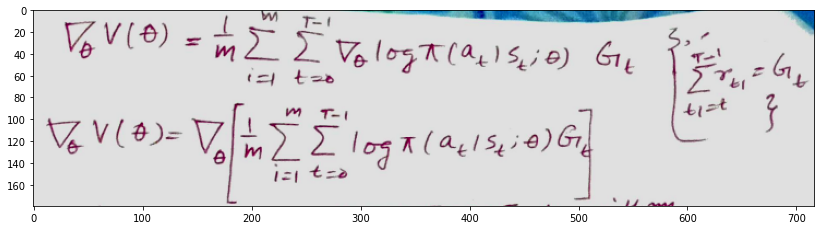

In [ ]:
image=cv2.imread("Reinforce.png")
plt.figure(figsize=(14,14))
plt.imshow(image)
plt.show()

In [ ]:
### Where Gt is the return for that time step or state. 
### log(pi(at|st :w)) is the logarithmic value of the probability of the action at on the state st
### by the policy pi given by the parameter w.  

### m is the number of samples collected.

### We are doing policy ascent, so, in this case, the weight update is done as:

### w = w + learning_rate * dV(w)/dw

### It is added not substracted.



In [ ]:
### Policy Gradient is useful as:

### 1. Unlike value based algorithms which directly predicts an action for a state, policy based algorithms
### predicts the probability for each action, on a state, the policy gradient can be used to generate stochastic 
### policies. Stochastic policies is very useful in several cases.

### 2. Can be more effective on case of large action spaces.

#### Disadvantages:

### 1. May converge to a local optimum instead of global optimum.
### 2. As it samples a policy and then calculates the gradient, it is computationally very expensive

### For advesarial cases, stochastic policy is required. 

### The estimate is a unbaised estimates of the gradient. 

In [ ]:
### Logical principle 

### Initially before gradient ascent, all of the actions on a state has equal to probability of occurence.
### if there are two possible actions, the probability of occurence for each action is 0.5

### After gradient ascent, the aim is to maximize the probability of occurence of the action, that maximizes value function.
### i.e, say return of action 1 is greater than action 2, G1>G2, it is expected that P[a1|s :w] will increase
### more than that of P[a2|s :w]

### Now, as G1 > G2 > 0, both the probabilities: P[a1|s :w] and P[a2|s :w] will be pushed towards 1, as, for log(P[a2|s :w])
### [0,1] -> [-inf,0], the gradient ascent will try to achieve the value 0. 

### Now, as G1>G2, the increase in P[a1|s :w] will be dominant and this way optimality is achieved. 

### But the increase in both the probabilities, creates a duality. which affects the sample efficiency of the algorithm

### As the model layers predict probability distribution of the action occurence on the state: "Softmax" is used on the last step

In [ ]:
### IN this cases, for policy based methods, the predicted policy for every state is the distribution
### of actions. To obtain the actions, we sample from the probability distributions, which is a completely
### random sampling. This is why they have an intrinsic degree of exploration, we do not need
### any E-greedy exploration strategy,

### Cartpole problem

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
### Tensorflow probability is a library that is used to generate a probability distribution
### from a softmax layer, sample from a distribution, and return the log value of the probability of the actions
### for the states.

In [ ]:
import gym

In [ ]:
env=gym.make('CartPole-v0')
env._max_episode_steps=200

In [ ]:
class Reinforce:
  def __init__(self,env):
    self.env=env
    self.state_dimension=env.observation_space.shape   ### Input state dimension
    self.no_of_action=env.action_space.n              ### No of actions
    self.agent=None      ### the learner 
    self.optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)  ### Optimizer
    self.goal=200
    self.m=300
   
  def get_model(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)
    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)

    output=tf.keras.layers.Dense(self.no_of_action,activation="softmax")(layer_3)
    ### The number of nodes in output layer is equal to the number of actions
    ### We generate probability, so we use softmax in last layer.

    model=tf.keras.Model(inputs=[input_layer],outputs=[output])

    return model
  
  def action(self,s):
    s=s.reshape(1,-1)
    ### Reshaping to obtain the probability of action for a single state:
    ### [0.5, 0.4, 0.2, 0.1] -> [[0.5, 0.4, 0.2, 0.1]]
    out=self.agent(s)
    action_prob=tfp.distributions.Categorical(probs=out)
    action= action_prob.sample()
    ### sampling an action from the obtained probability distributions for all the actions
    return action.numpy()[0]  ### Action returned as 1D tensor-> converting to scalar

  def log_prob(self,s,a):
    out=self.agent(s)
    ### again to be used in batch
    action_prob=tfp.distributions.Categorical(probs=out)
    ### takes in the states and the actions and returns the corresponding log probability 
    ### of the occurence of the taken action a on the state s
    ### log(P[a|s : w]) is obtained.
    
    return action_prob.log_prob(a)
  
  def loss(self,S,A,G):
    ### S is the state vector for the batch of size "m"
    ### A is the action vector for the batch of size "m"
    ### G is the return vector for the batch of size "m"

    m=S.shape[0] ### batch size
    log_pi_A_given_S=self.log_prob(S,A)  ### Obtaining log(Pi[a|s :w])
    #### log probability of the occurence of the taken action a on the state s

    #### Creating the loss function as given in the image above
    ### loss= (1/m)*(log(Pi[a|s :w]).G)
    ### as we need gradient ascent we multiply with -1
    return -1*tf.reduce_sum(tf.multiply(log_pi_A_given_S,G))/self.m
  
  def get_episodes(self):
    ### To sample raw walks in the environment
    states=[]
    actions=[]
    rewards=[]

    curr_state=self.env.reset()
    done=False

    while not done:
      action=self.action(curr_state)
      next_state,reward,done,_=self.env.step(action)
      ### Obtaining next step.

      states.append(curr_state)
      actions.append(action)
      rewards.append(reward)
      ### logging the essential required values for loss estimation

      curr_state=next_state ### Updating.

    return states,actions,rewards  ### All logs returned

  def get_returns(self,rewards,gamma=0.99):
    G=[] ## to log the returns for each state.
    ret=0
    for r in reversed(rewards):
      #### as we collect the rewards using forward propagation, and to calculate returns we 
      ### should backpropagate, so reversing the rewards array.
      ret= r + gamma*ret ### calculating return.
      G.insert(0,ret) ## we have reversed the reward array so, we are moving from back to front,
      ### So, we always insert in the front, as the fist element, which actually corresponds to
      ### the last step, moves back.
    
    return np.array(G)
  
  def get_experience(self,m):
    ### Get experience on the full batch :multiple sample
    states=[]
    actions=[]
    G=[]
    V=0
    for i in range(m):
      S,A,R=self.get_episodes()
      g=self.get_returns(R) 
      R=sum(R)
      ### For each episode in number of samples, collecting experience
      states.extend(S)
      actions.extend(A)
      G.extend(g)
      V+=R
      #### logging the stats of the ith sampling 
      ### "extend" not "append", as we want to create only one total set of episodes
    
    return np.array(states),np.array(actions),np.array(G),V/m

  
  def train(self):
    curr_v=0
    target_v=self.goal
    self.agent=self.get_model()

    i=1
    while curr_v<target_v:
      
      S,A,G,curr_v=self.get_experience(self.m)
      print(f"Sample {i}: V: {curr_v}")

      with tf.GradientTape() as t:
        J=self.loss(S,A,G)
      
      grads=t.gradient(J,self.agent.trainable_variables)
      self.optimizer.apply_gradients(zip(grads,self.agent.trainable_variables))

      i+=1



In [ ]:
agent=Reinforce(env)

In [ ]:
agent.train()

Sample 1: V: 22.71
Sample 2: V: 23.19
Sample 3: V: 26.253333333333334
Sample 4: V: 26.013333333333332
Sample 5: V: 29.096666666666668
Sample 6: V: 30.08
Sample 7: V: 34.36
Sample 8: V: 35.973333333333336
Sample 9: V: 36.876666666666665
Sample 10: V: 40.42333333333333
Sample 11: V: 42.093333333333334
Sample 12: V: 45.93333333333333
Sample 13: V: 53.096666666666664
Sample 14: V: 58.096666666666664
Sample 15: V: 60.693333333333335
Sample 16: V: 66.86333333333333
Sample 17: V: 79.75666666666666
Sample 18: V: 90.24333333333334
Sample 19: V: 105.98
Sample 20: V: 124.19
Sample 21: V: 134.80333333333334
Sample 22: V: 145.79666666666665
Sample 23: V: 160.90333333333334
Sample 24: V: 174.89333333333335
Sample 25: V: 179.26333333333332
Sample 26: V: 188.94666666666666
Sample 27: V: 194.47
Sample 28: V: 197.47666666666666
Sample 29: V: 198.28333333333333
Sample 30: V: 197.73
Sample 31: V: 198.24666666666667
Sample 32: V: 198.42333333333335
Sample 33: V: 197.92333333333335
Sample 34: V: 198.32
Samp